###Building the CNN model

In [ ]:
class IustNet(nn.Module):
    """
    TinyVGG-inspired model with dropout added to help mitigate overfitting.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Add dropout before classification
        self.dropout = nn.Dropout(p=0.5)
        # After two 2x2 pooling operations on a 224x224 input, the feature map is 56x56.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 56 * 56, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# Example instantiation (make sure input channels match your data, e.g., 3-channel):
model_IsutNet = IustNet(input_shape=3, hidden_units=50, output_shape=1).to(device)
model_IsutNet

IustNet(
  (block_1): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=156800, out_features=1, bias=True)
  )
)

In [ ]:
# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_IsutNet.parameters(),
                            lr=0.01)

In [ ]:
# Use a ReduceLROnPlateau scheduler - it reduces LR when a metric stops improving.
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',        # we want to maximize test_acc
    factor=0.1,        # scale the LR by 0.1
    patience=2,        # waits 2 epochs without improvement
    threshold=0.001,   # small improvement threshold
    verbose=True
)

In [ ]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    scheduler,
    loss_fn,
    epochs,
    device,
    patience=3
):
    best_test_acc = 0.0
    trigger_times = 0
    best_model_state = None

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        ##################
        # Training phase #
        ##################
        model.train()
        train_loss, train_correct = 0.0, 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += ((y_pred > 0).float() == y).sum().item()

        train_loss /= len(train_dataloader)
        train_acc = train_correct / len(train_dataloader.dataset)

        #################
        # Testing phase #
        #################
        model.eval()
        test_loss, test_correct = 0.0, 0
        with torch.no_grad():
            for X_test, y_test in test_dataloader:
                X_test, y_test = X_test.to(device), y_test.to(device).float().unsqueeze(1)
                test_pred = model(X_test)
                loss = loss_fn(test_pred, y_test)
                test_loss += loss.item()
                test_correct += ((test_pred > 0).float() == y_test).sum().item()

        test_loss /= len(test_dataloader)
        test_acc = test_correct / len(test_dataloader.dataset)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Store epoch results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Step LR scheduler with the test_acc
        scheduler.step(test_acc)

        ############################
        # Early Stopping Check    #
        ############################
        if test_acc > best_test_acc + 1e-5:
            # If test accuracy improved
            best_test_acc = test_acc
            best_model_state = model.state_dict()
            trigger_times = 0
        else:
            # No improvement
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                # Restore best model weights
                model.load_state_dict(best_model_state)
                break

    return results


In [ ]:
from timeit import default_timer as timer
start_time = timer()

results = train(
    model=model_IsutNet,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=15,
    device=device,
    patience=3  # Early stopping if no improvement for 3 epochs
)

end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3926 | train_acc: 0.8487 | test_loss: 0.7582 | test_acc: 0.6858
Epoch: 2 | train_loss: 0.3646 | train_acc: 0.8520 | test_loss: 1.2315 | test_acc: 0.5502
Epoch: 3 | train_loss: 0.3441 | train_acc: 0.8701 | test_loss: 1.1662 | test_acc: 0.6680
Epoch: 4 | train_loss: 0.2963 | train_acc: 0.8997 | test_loss: 1.1363 | test_acc: 0.6629
Epoch: 5 | train_loss: 0.3526 | train_acc: 0.8586 | test_loss: 0.9032 | test_acc: 0.6579
Epoch: 6 | train_loss: 0.2678 | train_acc: 0.9013 | test_loss: 0.9572 | test_acc: 0.6590
Epoch: 7 | train_loss: 0.3707 | train_acc: 0.8651 | test_loss: 0.8702 | test_acc: 0.6356
Epoch: 8 | train_loss: 0.3478 | train_acc: 0.8783 | test_loss: 0.7394 | test_acc: 0.6390
Epoch: 9 | train_loss: 0.2366 | train_acc: 0.9178 | test_loss: 0.9224 | test_acc: 0.6473
Epoch: 10 | train_loss: 0.1444 | train_acc: 0.9490 | test_loss: 2.0767 | test_acc: 0.6172
Epoch: 11 | train_loss: 0.2845 | train_acc: 0.8849 | test_loss: 1.4827 | test_acc: 0.6434
Epoch: 12 | train_l

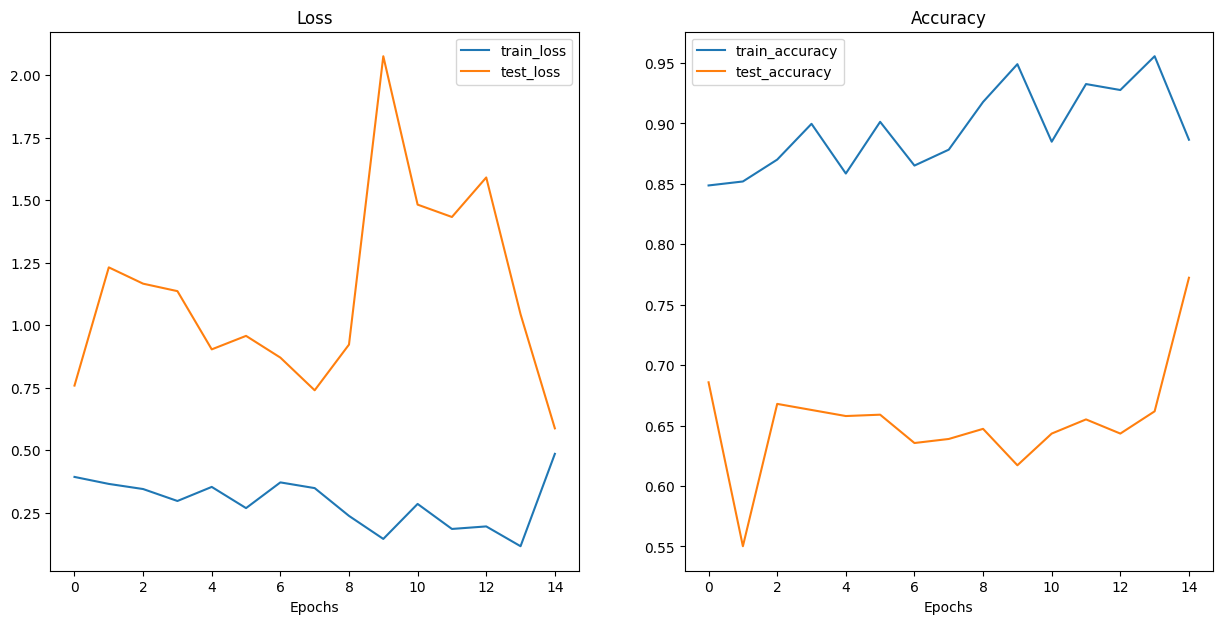

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Plots training curves of a model.

    Args:
        results (dict): Dictionary containing lists of train and test losses and accuracies.
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(14, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

plot_loss_curves(results) # Call the function after its definition


In [ ]:
!pip install torchmetrics -U mlxtend # we need mlxtend to plot the condusion matrix
import torchmetrics, mlxtend
print(f"mlxtend version {mlxtend.__version__}") # must be version 0.19.0 or higher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version 0.22.0


In [ ]:
from tqdm.auto import tqdm
y_preds = [] # list for storing the model predictions
y_targets = [] # list for storing the true labels of the test data
model_IsutNet.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions..."): # X and y are the image and label batches in the test dataloader
    X, y = X.to(device), y.to(device)
    y_targets.append(y.cpu())
    y_logit = model_IsutNet(X).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logit))
    y_preds.append(y_pred.cpu())

# concatenating all the prediction tensors into a single prediction tensor
y_pred_tensor = torch.cat(y_preds)
y_target_tensor = torch.cat(y_targets)
y_pred_tensor[:10], y_target_tensor[:10]

Making Predictions...:   0%|          | 0/8 [00:00<?, ?it/s]

(tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

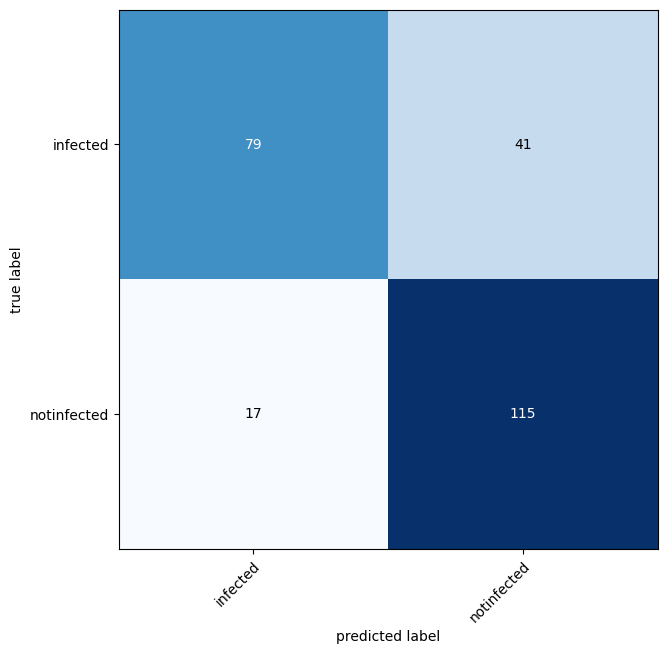

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
# Setup confusion matrix instance and compare predictions to targets
cm = ConfusionMatrix(task="binary", num_classes=len(class_names))
confmat_tensor = cm(preds=y_pred_tensor,
                         target=y_target_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)